In [1]:
import pandas as pd
import numpy as np
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from tqdm import tqdm

---
## magCVs data

### Getting data of selected magCVs from Fink's API

In [2]:
objids_list = list(pd.read_csv('../data/magnetic_cvs_objectId.csv').values.flatten()) # Reading IDs of selected magnetic Cataclysmic Variables
# Retrieving full objects data from Fink
r = requests.post(
  "https://api.fink-portal.org/api/v1/objects",
  json={
    "objectId": ",".join(objids_list),
    "columns": "i:objectId,d:anomaly_score,d:lc_features_g,d:lc_features_r",
    "output-format": "json"
  }
)

In [3]:
# From https://fink-broker.readthedocs.io/en/latest/services/search/anomaly_detection/
feature_names = ['mean', 'weighted_mean', 'standard_deviation', 'median', 'amplitude', 'beyond_1_std', 'cusum',
                 'inter_percentile_range_10', 'kurtosis', 'linear_trend', 'linear_trend_sigma', 'linear_trend_noise',
                 'linear_fit_slope', 'linear_fit_slope_sigma', 'linear_fit_reduced_chi2', 'magnitude_percentage_ratio_40_5',
                 'magnitude_percentage_ratio_20_10', 'maximum_slope', 'median_absolute_deviation', 'median_buffer_range_percentage_10',
                 'percent_amplitude', 'mean_variance', 'anderson_darling_normal', 'chi2', 'skew', 'stetson_K']

# Renaming to shorter names
feature_names = ['mean', 'weightedMean', 'std', 'median', 'amplitude', 'beyond1Std', 'cusum',
                       'IPR10', 'kurtosis', 'linT', 'linT_sigma', 'linT_noise',
                       'linF_slope', 'linF_slopeSigma', 'linF_reducedChi2', 'MPR40_5',
                       'MPR20_10', 'maxSlope', 'medianAbsDeviation', 'medianBuffRangePercent10',
                       'percentAmplitude', 'meanVariance', 'andersonDarlingNormal', 'chi2', 'skew', 'stetsonK']

### Cleaning data

In [4]:
pdf = pd.read_json(io.BytesIO(r.content))
# Converting values from str to float
placeholder_features_g, placeholder_features_r = [], []
for i in range(len(pdf)):
    placeholder_features_g.append(np.array(eval(pdf['d:lc_features_g'][i].replace("NaN", "np.nan").replace("null", "np.nan"))))
    placeholder_features_r.append(np.array(eval(pdf['d:lc_features_r'][i].replace("NaN", "np.nan").replace("null", "np.nan"))))

pdf['d:lc_features_g'] = placeholder_features_g
pdf['d:lc_features_r'] = placeholder_features_r

In [6]:
clean_pdf = pdf[~np.isnan(pdf["d:anomaly_score"])] # Getting rid of lines with NaN in the anomaly_score column

clean_pdf_g = clean_pdf.drop(columns=["d:lc_features_r"])
clean_pdf_r = clean_pdf.drop(columns=["d:lc_features_g"])

for index, lc_features_g, lc_features_r in zip(clean_pdf.index, clean_pdf_g["d:lc_features_g"], clean_pdf_r["d:lc_features_r"]):
    if len(lc_features_g) == 0 or True in np.isnan(lc_features_g):
        clean_pdf_g = clean_pdf_g.drop([index]) # Getting rid of empty lines or with NaN values
    if len(lc_features_r) == 0 or True in np.isnan(lc_features_r):
        clean_pdf_r = clean_pdf_r.drop([index])

print(f'{len(clean_pdf_g)} and {len(clean_pdf_r)} lines remaining in g and r filters respectively after cleaning out of {len(pdf)}')

4404 and 4362 lines remaining in g and r filters respectively after cleaning out of 24758


In [7]:
# Removing duplicates
features_g, features_r = np.vstack(clean_pdf_g["d:lc_features_g"].to_numpy()), np.vstack(clean_pdf_r["d:lc_features_r"].to_numpy()) # Used vstack here to have 2D arrays instead of array of arrays
features_g_reduced = np.unique(features_g, axis=0)
features_r_reduced = np.unique(features_r, axis=0)
print(f'{len(features_g_reduced)} out of {len(features_g)} and {len(features_r_reduced)} out of {len(features_r)} lines remaining in g and r filters respectively after removing duplicates')

3837 out of 4404 and 4007 out of 4362 lines remaining in g and r filters respectively after removing duplicates


In [8]:
dfg = pd.DataFrame(features_g_reduced, columns=feature_names)
dfr = pd.DataFrame(features_r_reduced, columns=feature_names)

### Corner plots of some features

#### Using Seaborn

In [ ]:
sns.pairplot(dfg[feature_names[:4]], corner=True, plot_kws={'s': 2, 'alpha': 0.2});

In [ ]:
sns.pairplot(dfg[feature_names[4:8]], corner=True, plot_kws={'s': 2, 'alpha': 0.2});

In [ ]:
sns.pairplot(dfg[feature_names[8:12]], corner=True, plot_kws={'s': 2, 'alpha': 0.2});

In [ ]:
sns.pairplot(dfg[feature_names[12:16]], corner=True, plot_kws={'s': 2, 'alpha': 0.2});

In [ ]:
sns.pairplot(dfg[feature_names[16:20]], corner=True, plot_kws={'s': 2, 'alpha': 0.2});

In [ ]:
sns.pairplot(dfg[feature_names[20:24]], corner=True, plot_kws={'s': 2, 'alpha': 0.2});

In [ ]:
sns.pairplot(dfg[feature_names[24:]], corner=True, plot_kws={'s': 2, 'alpha': 0.2});

#### Light function for heavy plots

In [40]:
def corner_plot(df: pd.DataFrame, df2: pd.DataFrame = None, *,show_hist_count: bool = False) -> None:
    """Make a corner plot which dimension is the number of columns of the DataFrame

    Args:
        df (pd.DataFrame): DataFrame containing the data to plot
        show_hist_count (bool, optional): Whether to show histograms counts. Defaults to False.
    """
    n = len(df.columns) # Dimension of the corner plot
    # Plotting histograms:
    index = 1
    for feature_name in df.columns:
        plt.subplot(n, n, index)
        plt.hist(df[feature_name], bins=np.linspace(min(df[feature_name]), max(df[feature_name]), 30), density=True, alpha=0.5)
        if df2 is not None:
            plt.hist(df2[feature_name], bins=np.linspace(min(df2[feature_name]), max(df2[feature_name]), 30), density=True, alpha=0.5)
        if index == n*n:
            plt.xlabel(feature_name)
        else:
            plt.xticks([])
        if not show_hist_count:
            plt.yticks([])
        index += n + 1
    # Plotting scatter plots:
    feature_pairs = tuple(combinations(df.columns, 2))
    pair = 0
    for i in range(1, n):
        for j in range(i, n):
            plt.subplot(n, n, j*n + i)
            plt.scatter(df[feature_pairs[pair][0]], df[feature_pairs[pair][1]], s=1, alpha=0.1)
            if df2 is not None:
                plt.scatter(df2[feature_pairs[pair][0]], df2[feature_pairs[pair][1]], s=1, alpha=0.1)
            if i == 1:
                plt.ylabel(feature_pairs[pair][1])
            else:
                plt.yticks([])
            if j == n - 1:
                plt.xlabel(feature_pairs[pair][0])
            else:
                plt.xticks([])
            pair += 1

    return

##### Plot of all possible feature pairs (g filter)

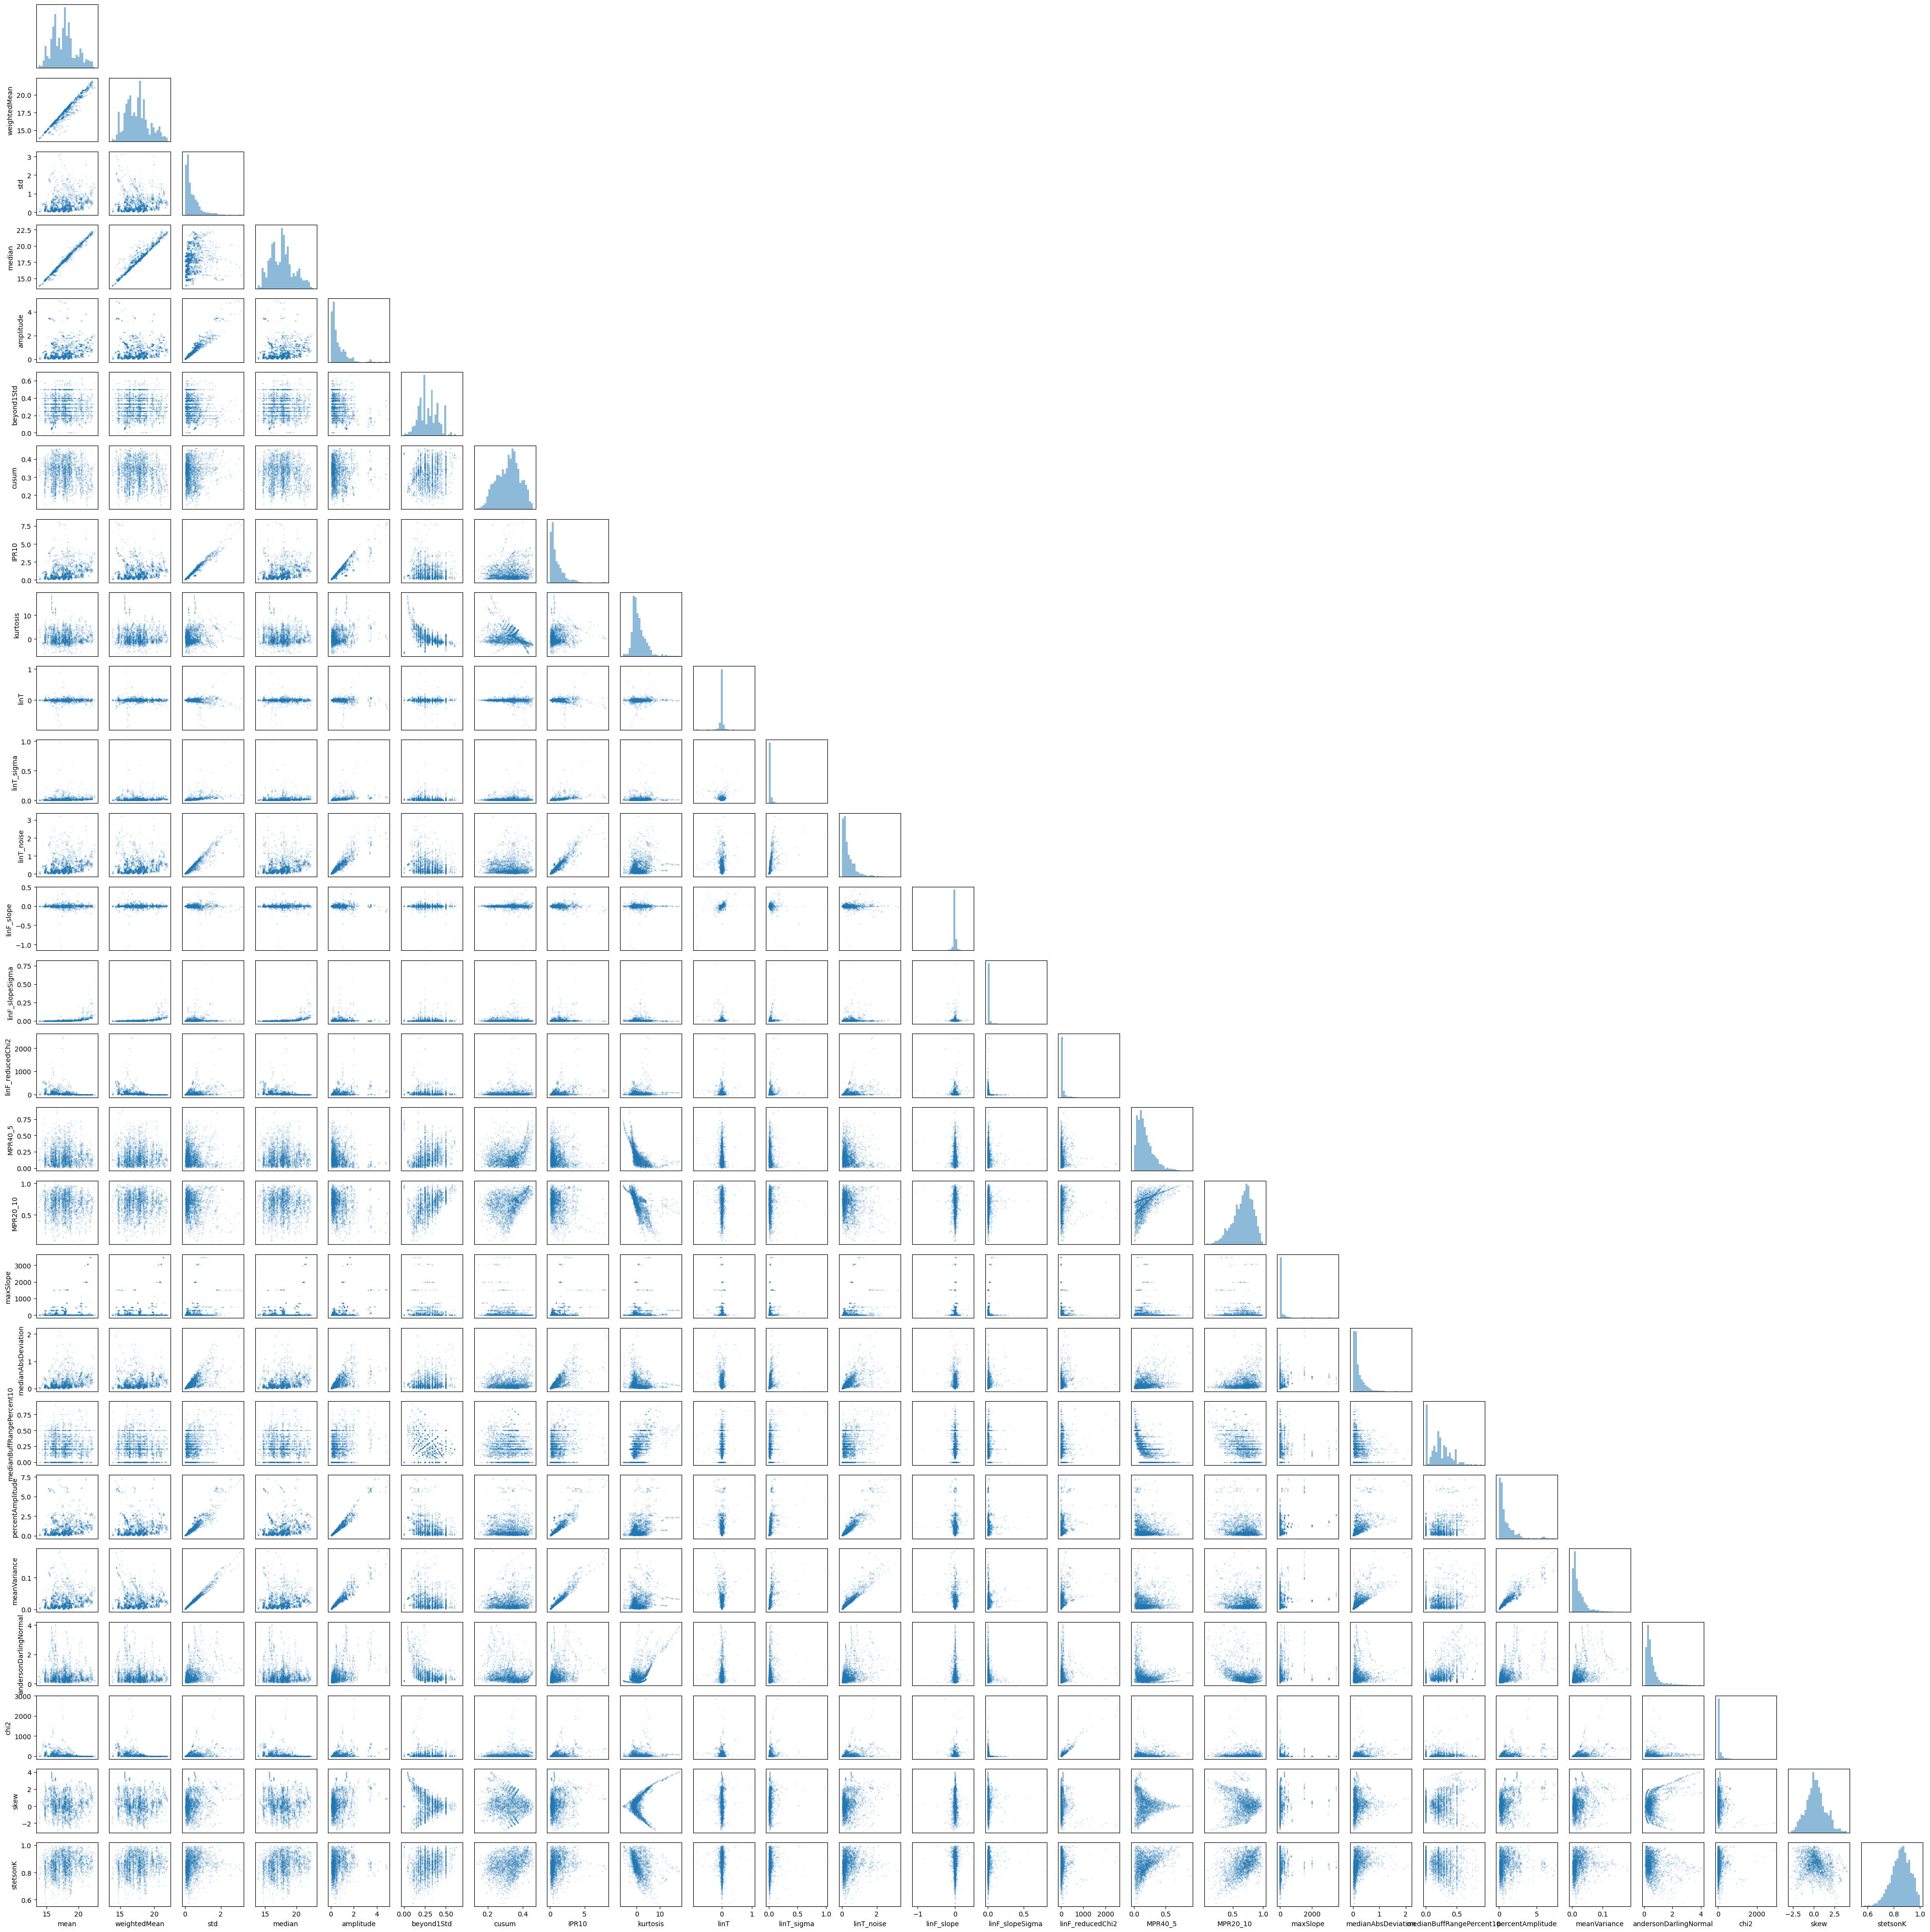

In [41]:
plt.figure(figsize=(40, 40))
corner_plot(dfg[feature_names[:26]]) 
plt.tight_layout()

##### Plot of all possible feature pairs (r filter)

In [ ]:
plt.figure(figsize=(40, 40))
corner_plot(dfr[feature_names[:26]]) 
plt.tight_layout()

---
## Other lc data

### Getting other lc data

In [11]:
path_to_other_data = '../../lc_features_not_nan_JAN2024/' # To be changed accordingly
pdf2 = pd.read_parquet(path_to_other_data)

### Cleaning data

In [15]:
# Converting the lines of dictionaries to lines of arrays with only the values of the dictionaries
placeholder_features_g2, placeholder_features_r2 = [], []
clean_pdf2 = pd.DataFrame()
for i in tqdm(range(len(pdf2))):
    placeholder_features_g2.append(np.array(list(pdf2['lc_features_g'][i].values())))
    placeholder_features_r2.append(np.array(list(pdf2['lc_features_r'][i].values())))

clean_pdf2['lc_features_g'], clean_pdf2['lc_features_r'] = placeholder_features_g2, placeholder_features_r2

100%|██████████| 854991/854991 [00:10<00:00, 84903.56it/s]


In [16]:
clean_pdf_g2, clean_pdf_r2 = clean_pdf2.drop(columns=["lc_features_r"]), clean_pdf2.drop(columns=["lc_features_g"])
nans_g = np.array([], dtype=bool)
nans_r = np.array([], dtype=bool)
for lc_features_g, lc_features_r in zip(tqdm(clean_pdf_g2["lc_features_g"]), clean_pdf_r2["lc_features_r"]):
    nans_g = np.append(nans_g, True in np.isnan(lc_features_g))
    nans_r = np.append(nans_r, True in np.isnan(lc_features_r))
clean_pdf_g2, clean_pdf_r2 = clean_pdf_g2[~nans_g], clean_pdf_r2[~nans_r]

100%|██████████| 854991/854991 [00:46<00:00, 18387.27it/s]


In [18]:
print(f'{len(clean_pdf_g2)} and {len(clean_pdf_r2)} lines remaining in g and r filters respectively after cleaning out of {len(clean_pdf2)}')

370116 and 476192 lines remaining in g and r filters respectively after cleaning out of 854991


In [19]:
features_g2, features_r2 = np.vstack(clean_pdf_g2["lc_features_g"].to_numpy()), np.vstack(clean_pdf_r2["lc_features_r"].to_numpy())
features_g_reduced2 = np.unique(features_g2, axis=0)
features_r_reduced2 = np.unique(features_r2, axis=0)
print(f'{len(features_g_reduced2)} out of {len(features_g2)} and {len(features_r_reduced2)} out of {len(features_r2)} lines remaining in g and r filters respectively after removing duplicates')

280737 out of 370116 and 458436 out of 476192 lines remaining in g and r filters respectively after removing duplicates


In [20]:
dfg2 = pd.DataFrame(features_g_reduced2, columns=feature_names)
dfr2 = pd.DataFrame(features_r_reduced2, columns=feature_names)

---
## Comparison

In [21]:
dfg['Stype'] = 'magCVs'
dfg2['Stype'] = 'other'
# concatenating the two DataFrames
dfg_all = pd.concat([dfg, dfg2], ignore_index=True)

In [22]:
dfg_all

mean  weightedMean       std     median  amplitude  beyond1Std  \
0       13.817506     13.828649  0.195803  13.896276   0.234263    0.200000   
1       13.817509     13.828649  0.195798  13.896276   0.234256    0.200000   
2       13.869760     13.870895  0.063930  13.895045   0.080594    0.400000   
3       13.900870     13.893656  0.048767  13.896276   0.060799    0.200000   
4       13.902325     13.893262  0.056184  13.918694   0.060799    0.250000   
...           ...           ...       ...        ...        ...         ...   
284569  24.023495     22.559252  2.352622  23.108665   3.228108    0.222222   
284570  24.026790     21.846678  1.523445  24.601112   2.036881    0.333333   
284571  24.114702     23.096294  1.175099  24.073582   1.310470    0.500000   
284572  24.192055     22.695741  1.807143  23.857152   2.070526    0.250000   
284573  24.395852     21.400130  2.470488  24.407039   3.011165    0.500000   

           cusum     IPR10  kurtosis      linT  ...    maxSlope  \
0       0.346548  0.468526  3.736549 -0.012028  ...    0.146128   
1       0.346548  0.468512  3.736476 -0.012028  ...    0.146124   
2       0.402923  0.161188 -1.246543  0.001090  ...    0.035345   
3       0.329353  0.121598  0.822606  0.000070  ...    0.012500   
4       0.370289  0.121598  0.423473 -0.000262  ...    0.012500   
...          ...       ...       ...       ...  ...         ...   
284569  0.314860  5.909403  1.013141 -1.436161  ...  134.165012   
284570  0.329666  3.880800 -0.696678  0.073224  ...   84.364607   
284571  0.287548  2.620941 -2.685482 -0.010362  ...    0.496159   
284572  0.332767  4.141052  0.064208  0.255339  ...  101.702022   
284573  0.334665  6.022331  1.216102  3.376451  ...   47.051004   

        medianAbsDeviation  medianBuffRangePercent10  percentAmplitude  \
0                 0.050480                  0.200000          0.418046   
1                 0.050480                  0.200000          0.418033   
2                 0.051710                  0.400000          0.109477   
3                 0.044842                  0.400000          0.071118   
4                 0.025240                  0.000000          0.093537   
...                    ...                       ...               ...   
284569            0.375340                  0.333333          5.576612   
284570            0.692992                  0.333333          2.905020   
284571            0.910161                  0.000000          1.392710   
284572            1.011507                  0.000000          2.740332   
284573            1.642383                  0.500000          3.033540   

        meanVariance  andersonDarlingNormal        chi2      skew  stetsonK  \
0           0.014171               0.515629  143.749041 -1.915839  0.754049   
1           0.014170               0.515619  143.744461 -1.915821  0.754053   
2           0.004609               0.204758   14.404587 -0.309796  0.915388   
3           0.003508               0.280313   14.517087 -0.979036  0.762692   
4           0.004041               0.147103   19.350766 -1.179132  0.848727   
...              ...                    ...         ...       ...       ...   
284569      0.097930               1.443811    0.026064  1.577451  0.847633   
284570      0.063406               0.372272    0.065852 -0.757941  0.931704   
284571      0.048730               0.086808    0.009493  0.138541  0.992715   
284572      0.074700               0.097480    0.043642  0.885211  0.912241   
284573      0.101267               0.090087    0.029456 -0.026649  0.797469   

         Stype  
0       magCVs  
1       magCVs  
2       magCVs  
3       magCVs  
4       magCVs  
...        ...  
284569   other  
284570   other  
284571   other  
284572   other  
284573   other  

[284574 rows x 27 columns]

### With Seaborn

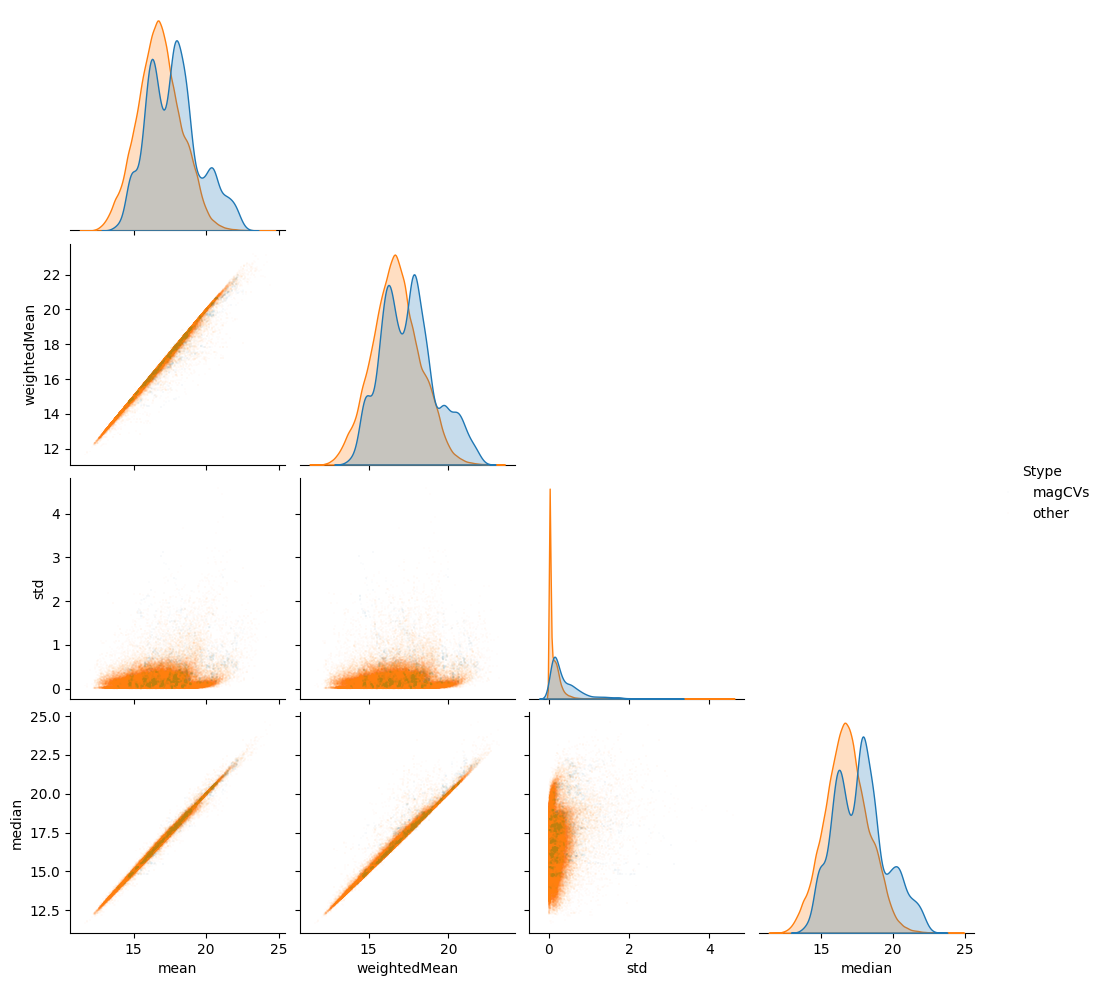

In [33]:
sns.pairplot(dfg_all, vars=feature_names[:4], hue='Stype', markers=['_', '|'], corner=True, diag_kws={'common_norm': False}, plot_kws={'s': 2, 'alpha': 0.2});

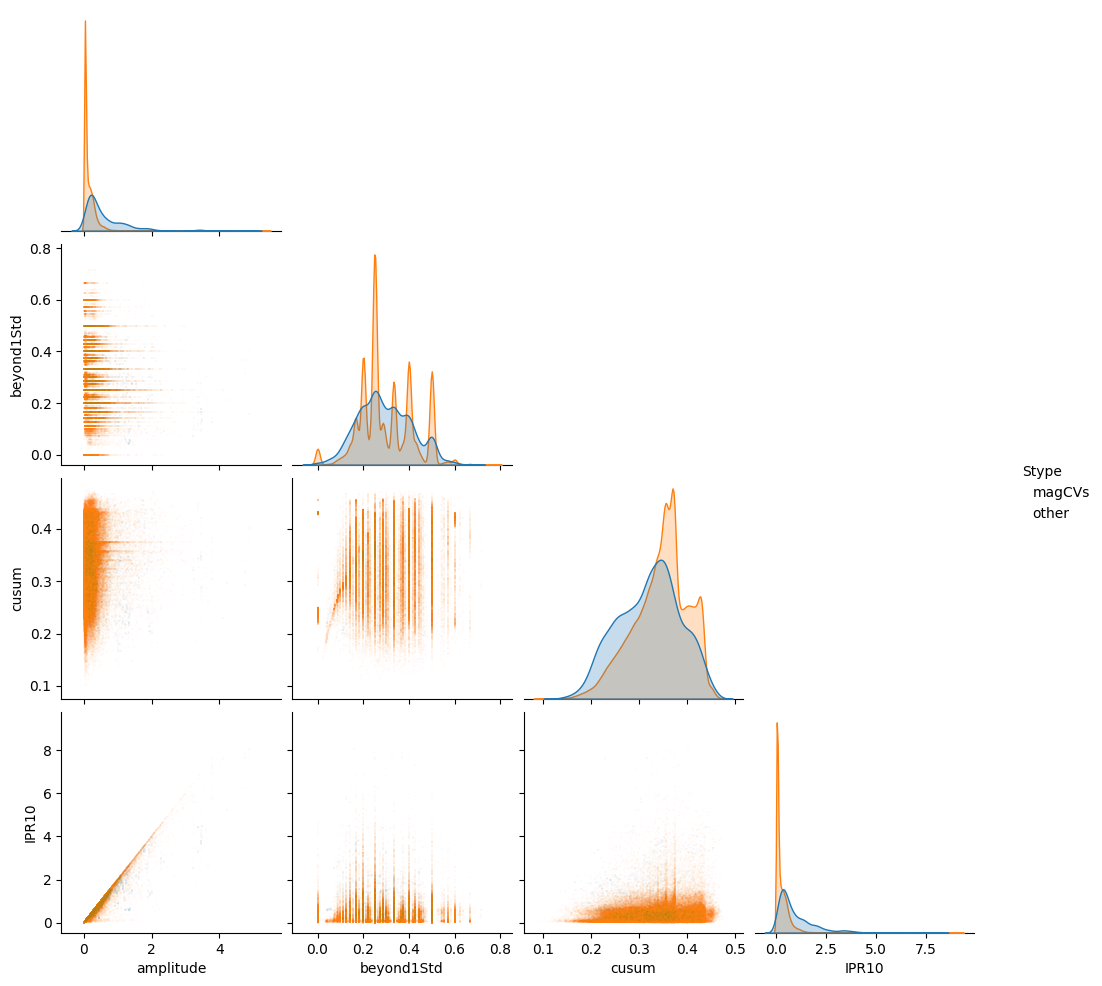

In [34]:
sns.pairplot(dfg_all, vars=feature_names[4:8], hue='Stype', markers=['_', '|'], corner=True, diag_kws={'common_norm': False}, plot_kws={'s': 2, 'alpha': 0.2});

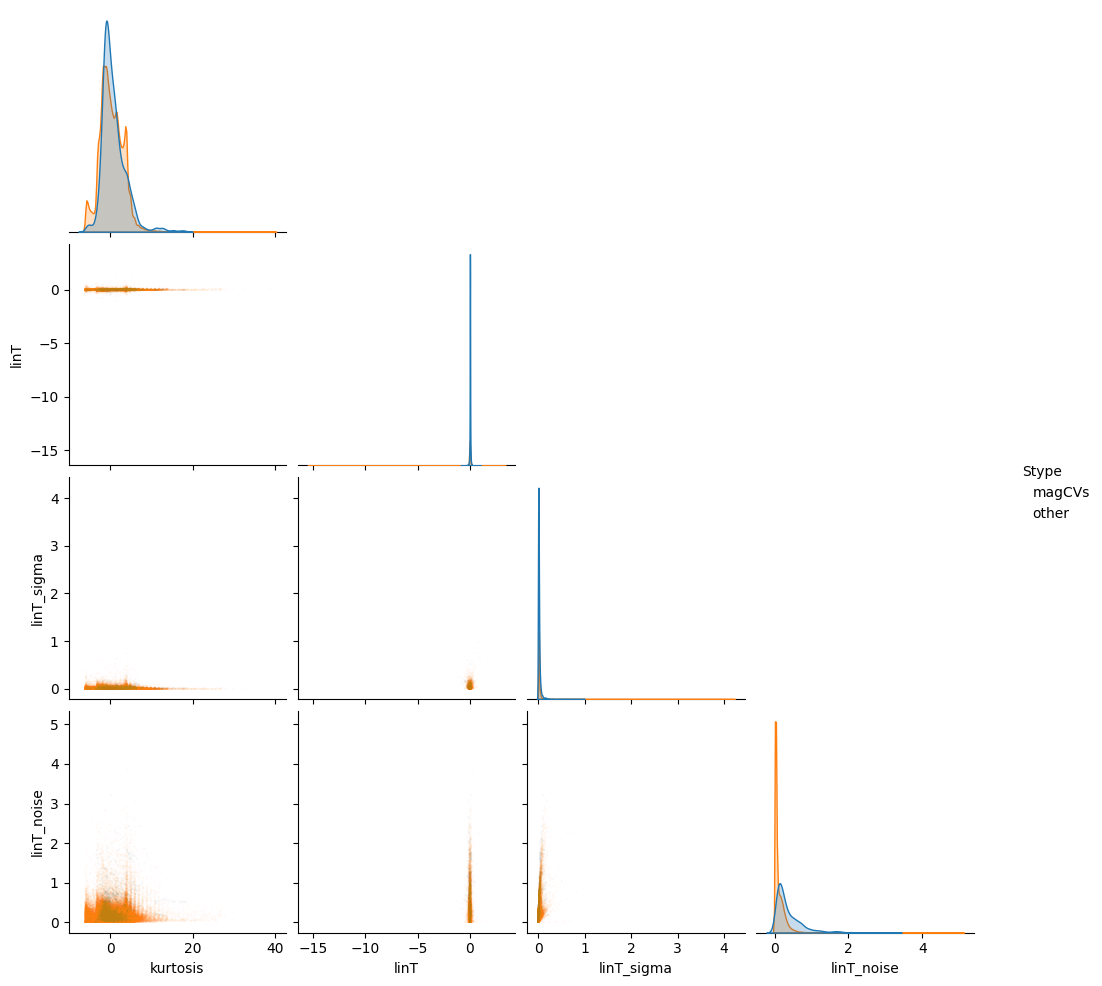

In [35]:
sns.pairplot(dfg_all, vars=feature_names[8:12], hue='Stype', markers=['_', '|'], corner=True, diag_kws={'common_norm': False}, plot_kws={'s': 2, 'alpha': 0.2});

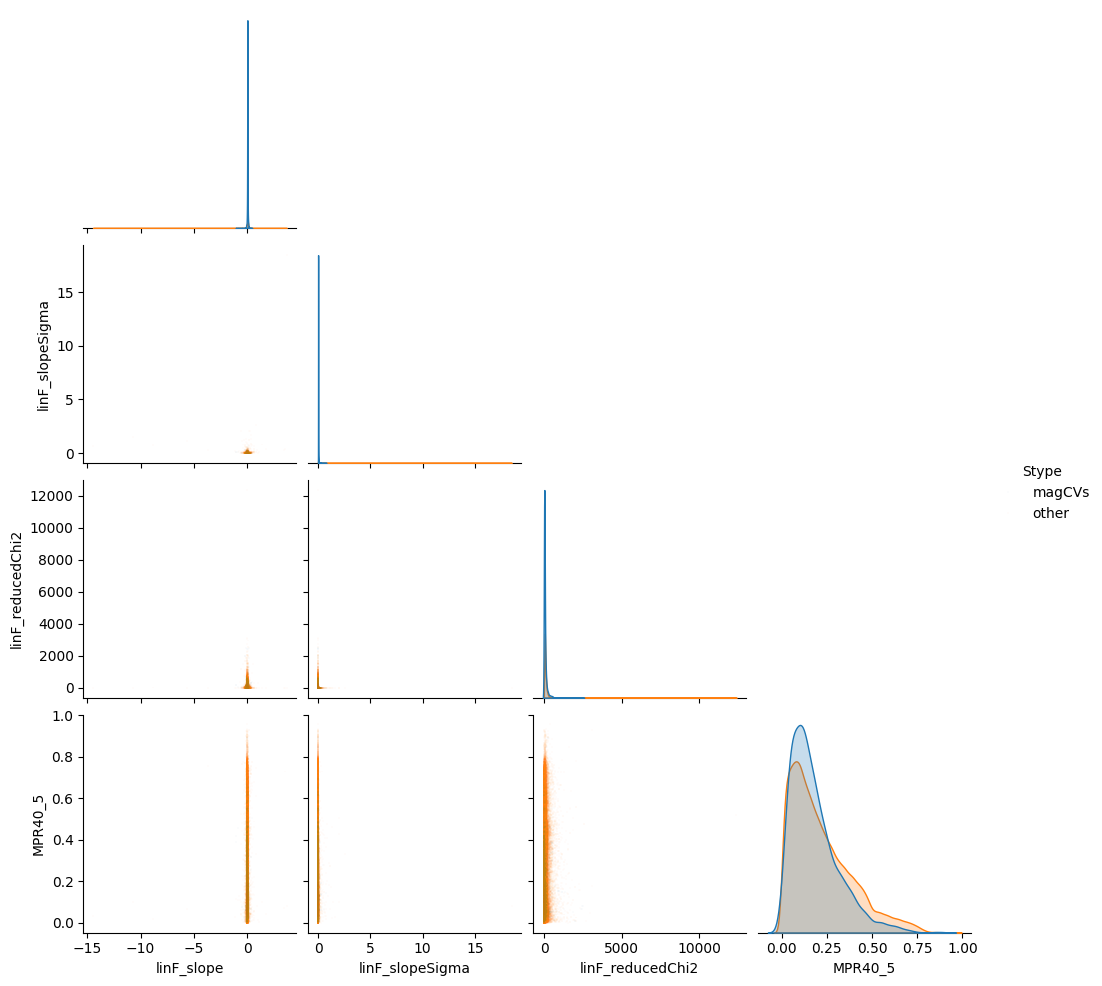

In [36]:
sns.pairplot(dfg_all, vars=feature_names[12:16], hue='Stype', markers=['_', '|'], corner=True, diag_kws={'common_norm': False}, plot_kws={'s': 2, 'alpha': 0.2});

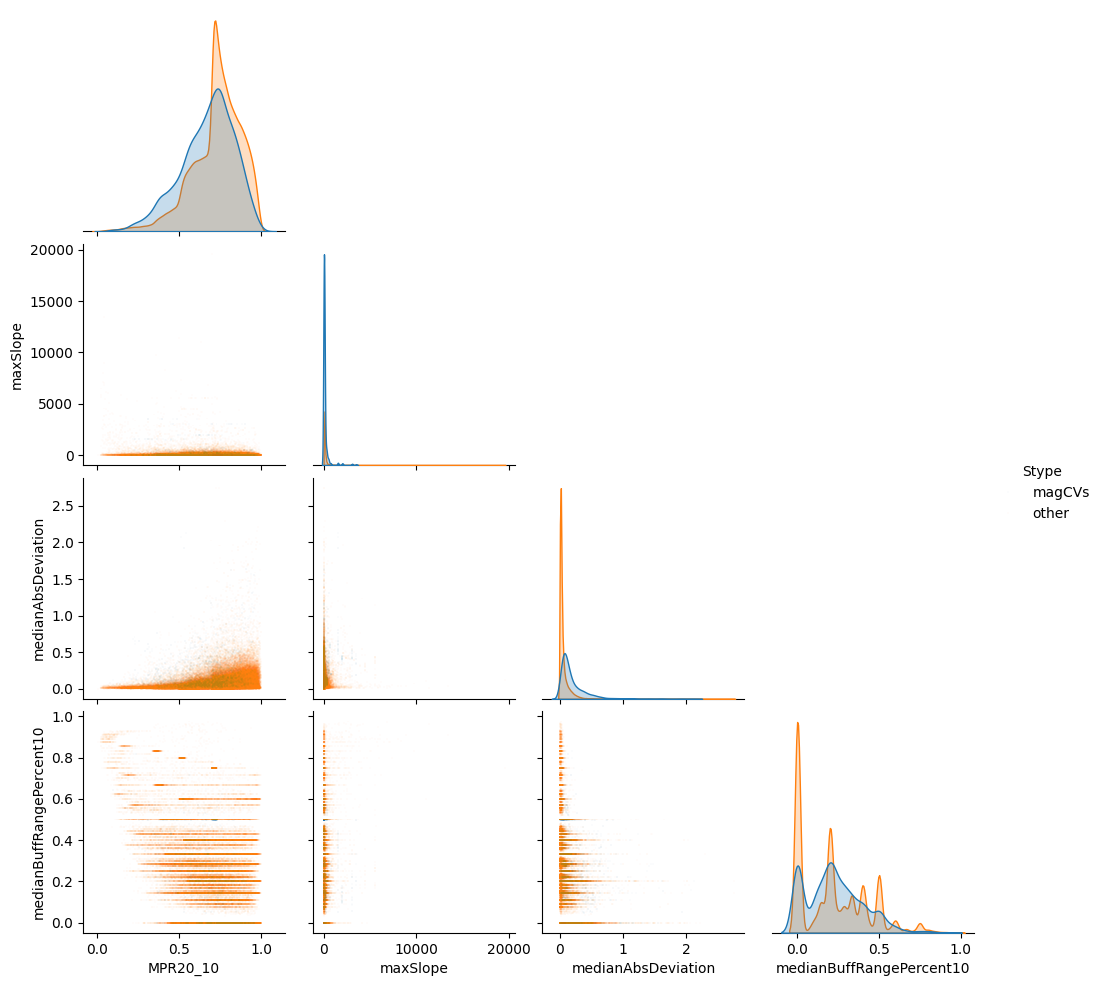

In [37]:
sns.pairplot(dfg_all, vars=feature_names[16:20], hue='Stype', markers=['_', '|'], corner=True, diag_kws={'common_norm': False}, plot_kws={'s': 2, 'alpha': 0.2});

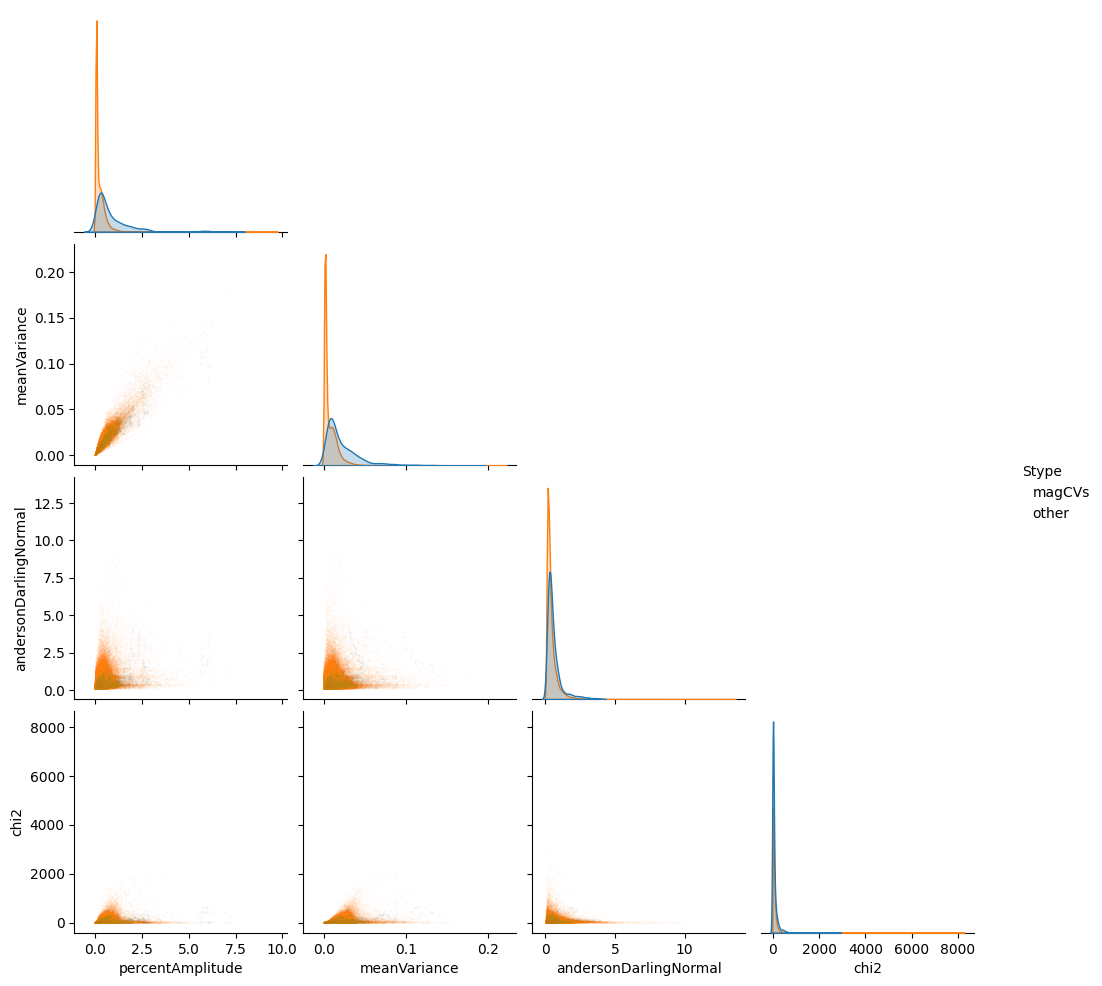

In [38]:
sns.pairplot(dfg_all, vars=feature_names[20:24], hue='Stype', markers=['_', '|'], corner=True, diag_kws={'common_norm': False}, plot_kws={'s': 2, 'alpha': 0.2});

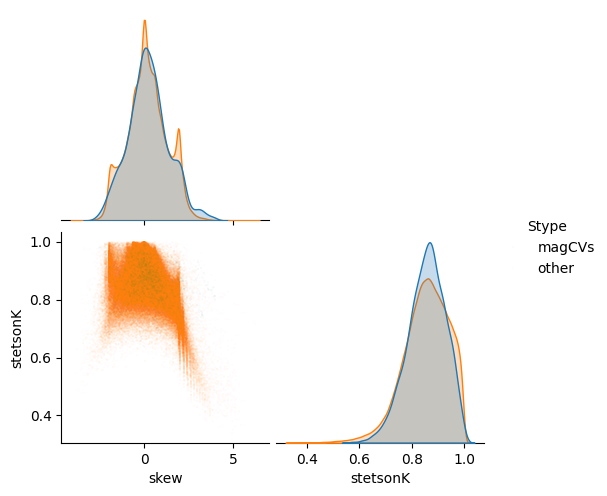

In [39]:
sns.pairplot(dfg_all, vars=feature_names[24:], hue='Stype', markers=['_', '|'], corner=True, diag_kws={'common_norm': False}, plot_kws={'s': 2, 'alpha': 0.2});

### With light function

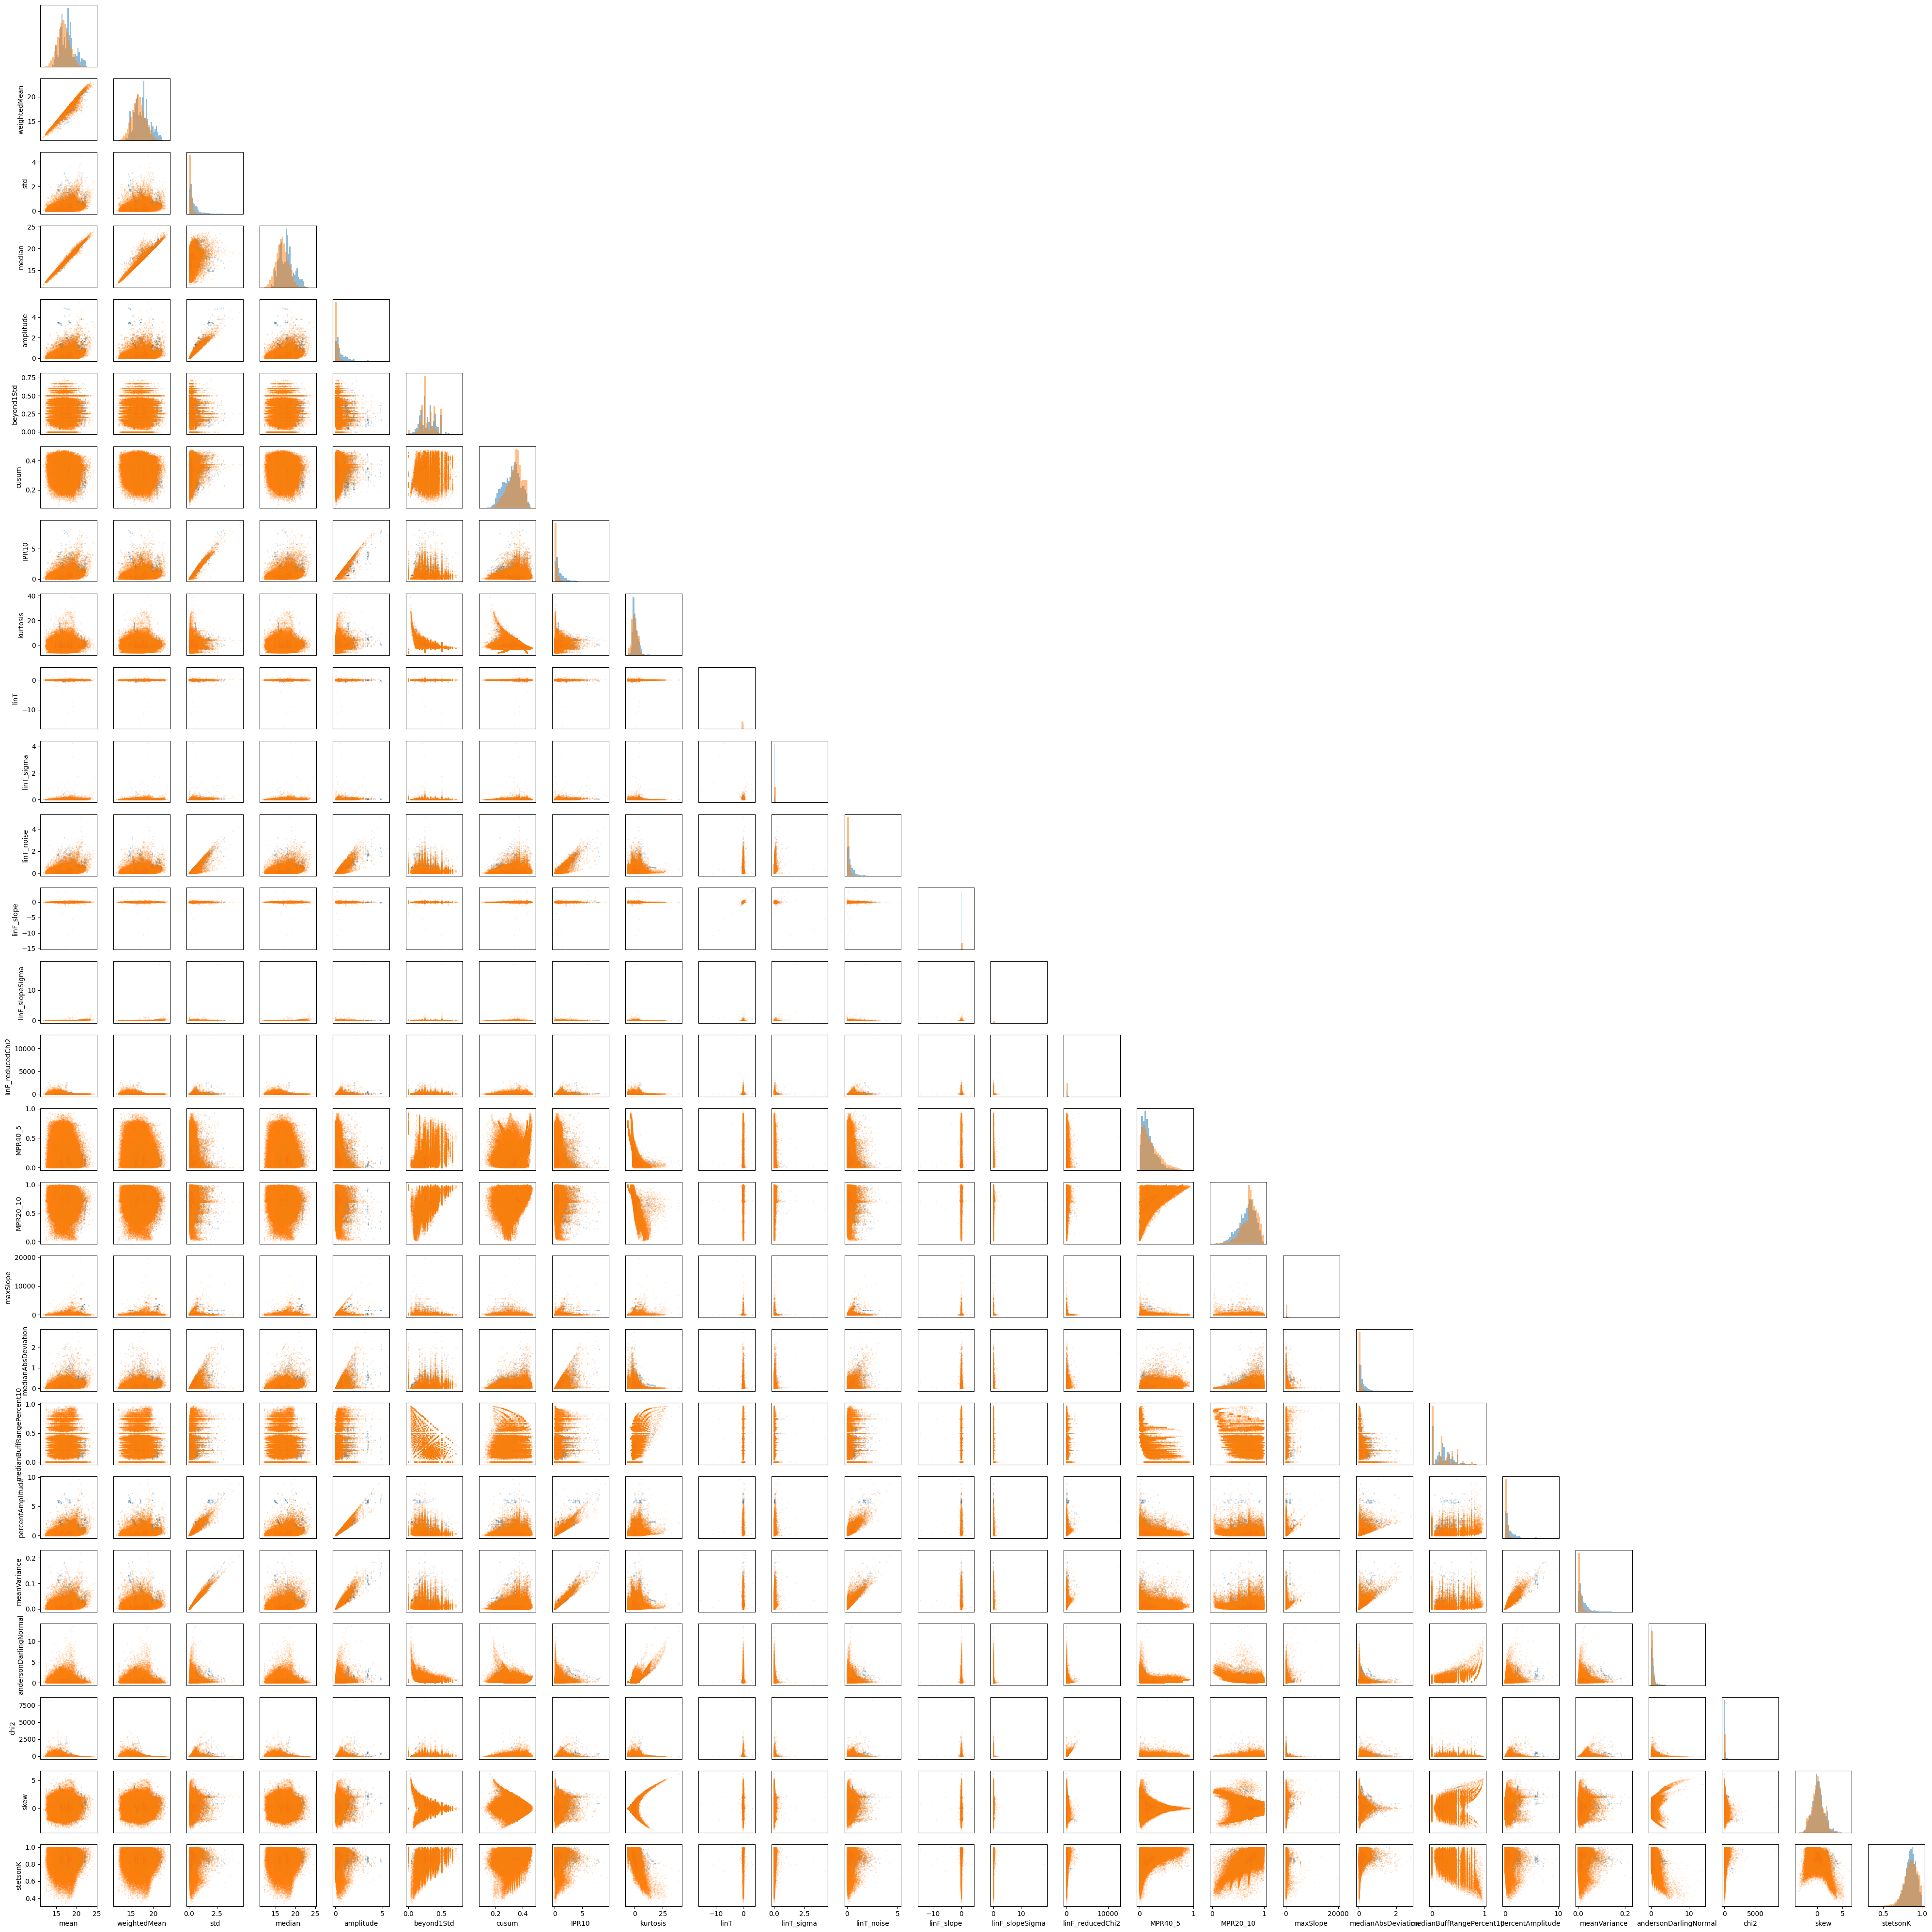

In [49]:
plt.figure(figsize=(40, 40))
corner_plot(dfg[feature_names], dfg2[feature_names])
plt.tight_layout()

---
## Test Zone

In [ ]:
plt.figure(figsize=(40, 40))
corner_plot(dfg2[feature_names[:26]])
plt.tight_layout()

In [ ]:
sns.pairplot(dfg2[feature_names[:10]], corner=True, plot_kws={'s': 2, 'alpha': 0.2})

In [ ]:
sns.pairplot(dfg_all, vars=feature_names[:2], corner=True, hue='Stype');